In [17]:
import collections
import re
from d2l.d2l import d2l

# 数据集

In [46]:
# @save
d2l.DATA_HUB["time_machine"] = (d2l.DATA_URL + "timemachine.txt", "090b5e7e70c295757f55df93cb0a180b9691891a")


def read_time_machine():  # @save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download("time_machine"), "r") as f:
        lines = f.readlines()
    return [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]


lines = read_time_machine()
print(f"# 文本总行数: {len(lines)}")
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [47]:
def tokenize(lines, token="word"):  # @save
    """将文本行拆分为单词或字符词元"""
    if token == "word":
        return [line.split() for line in lines if len(line) > 0]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("错误：未知词元类型：" + token)


tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
['i']
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
['fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent']
['lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and']
['passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and']
['caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that']
['luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully']
['free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this']


In [48]:
class Vocab:  # @save
    """文本词表"""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = Vocab.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ["<unk>"] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

    @staticmethod
    def count_corpus(tokens):  # @save
        """统计词元的频率"""
        # 这里的tokens是1D列表或2D列表
        if len(tokens) == 0 or isinstance(tokens[0], list):
            # 将词元列表展平成一个列表
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)

In [49]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [50]:
for i in [0, 10]:
    print("文本:", tokens[i])
    print("索引:", vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this']
索引: [827, 4, 1, 2199, 4, 2200, 3, 27, 132, 11, 6, 126, 8, 21]


In [51]:
def load_corpus_time_machine(max_tokens=-1):  # @save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, "char")
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

# n-gram

In [52]:
import random
import torch
from d2l.d2l import d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

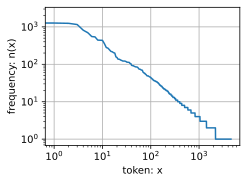

In [53]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel="token: x", ylabel="frequency: n(x)", xscale="log", yscale="log")

In [54]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [55]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

In [56]:
def seq_data_iter_random(corpus, batch_size, num_steps):  # @save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1) :]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos : pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [57]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print("X: ", X, "\nY:", Y)

X:  tensor([[26, 27, 28, 29, 30],
        [11, 12, 13, 14, 15]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [12, 13, 14, 15, 16]])
X:  tensor([[ 1,  2,  3,  4,  5],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [22, 23, 24, 25, 26]])
X:  tensor([[16, 17, 18, 19, 20],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [ 7,  8,  9, 10, 11]])


In [58]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  # @save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset : offset + num_tokens])

    Ys = torch.tensor(corpus[offset + 1 : offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i : i + num_steps]
        Y = Ys[:, i : i + num_steps]
        yield X, Y

In [59]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print("X: ", X, "\nY:", Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [60]:
class SeqDataLoader:  # @save
    """加载序列数据的迭代器"""

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [61]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):  # @save
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [62]:
data, vocab = load_data_time_machine(2, 5)

In [63]:
for x, y in data:
    print(x, y)
    break

tensor([[ 2,  1,  3,  5, 13],
        [12, 14, 11,  2,  1]]) tensor([[ 1,  3,  5, 13,  2],
        [14, 11,  2,  1, 17]])


# rnn 从零开始

In [18]:
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [65]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [66]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [67]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [68]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [69]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    (H,) = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [70]:
class RNNModelScratch:  # @save
    """从零开始实现的循环神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [71]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [72]:
def predict_ch8(prefix, num_preds, net, vocab, device):  # @save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return "".join([vocab.idx_to_token[i] for i in outputs])


predict_ch8("time traveller ", 10, net, vocab, d2l.try_gpu())

'time traveller kgfvoigfvo'

In [73]:
def grad_clipping(net, theta):  # @save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [74]:
# @save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [75]:
# @save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel="epoch", ylabel="perplexity", legend=["train"], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict("time traveller"))
            animator.add(epoch + 1, [ppl])
    print(f"困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}")
    print(predict("time traveller"))
    print(predict("traveller"))

困惑度 1.0, 38620.2 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


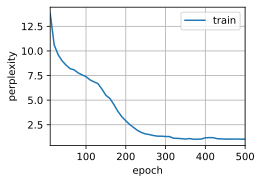

In [76]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

# rnn pytorch

In [77]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [78]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [79]:
# rnn层数 批量 隐单元数
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [80]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
# 与从零实现的rnn不同
# rnn的输入是(time_steps, bs, num_hiddens) 
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [19]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens, batch_first=True)
# rnn层数 批量 隐单元数
state = torch.zeros((1, batch_size, num_hiddens))
X = torch.rand(size=(batch_size, num_steps, len(vocab)))
Y, state_new = rnn_layer(X, state)
# 与从零实现的rnn不同
# rnn的输入是(time_steps, bs, num_hiddens) 
Y.shape, state_new.shape

(torch.Size([32, 35, 256]), torch.Size([1, 32, 256]))

In [81]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [82]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerggggfhgfgf'

困惑度 1.3, 263105.7 词元/秒 cuda:0
time traveller hal oins doan anong the time travellerit s agains
traveller came back andfilby s ane dote and urasued a coult


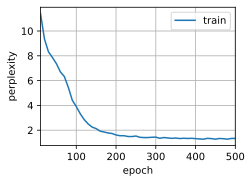

In [83]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)